Valeurs manquantes par colonne :
LotFrontage    259
MasVnrArea       8
dtype: int64

Statistiques descriptives :
         MSSubClass  LotFrontage       LotArea     LotShape  LandContour  \
count  1.458000e+03  1458.000000  1.458000e+03  1458.000000  1458.000000   
mean  -8.223874e-17     0.008811 -2.436703e-18     0.406036     0.184499   
std    1.000343e+00     0.907350  1.000343e+00     0.578514     0.606174   
min   -1.163246e+00    -2.686098 -3.642824e+00     0.000000     0.000000   
25%   -1.163246e+00    -0.360515 -3.597847e-01     0.000000     0.000000   
50%    2.437582e-01     0.049601  8.307226e-02     0.000000     0.000000   
75%    6.988544e-01     0.474237  4.798357e-01     1.000000     0.000000   
max    1.869780e+00     6.815593  6.585005e+00     3.000000     3.000000   

         LotConfig   OverallQual   OverallCond     YearBuilt  YearRemodAdd  \
count  1458.000000  1.458000e+03  1.458000e+03  1.458000e+03  1.458000e+03   
mean      0.510288 -2.826576e-16  3.094613e-16

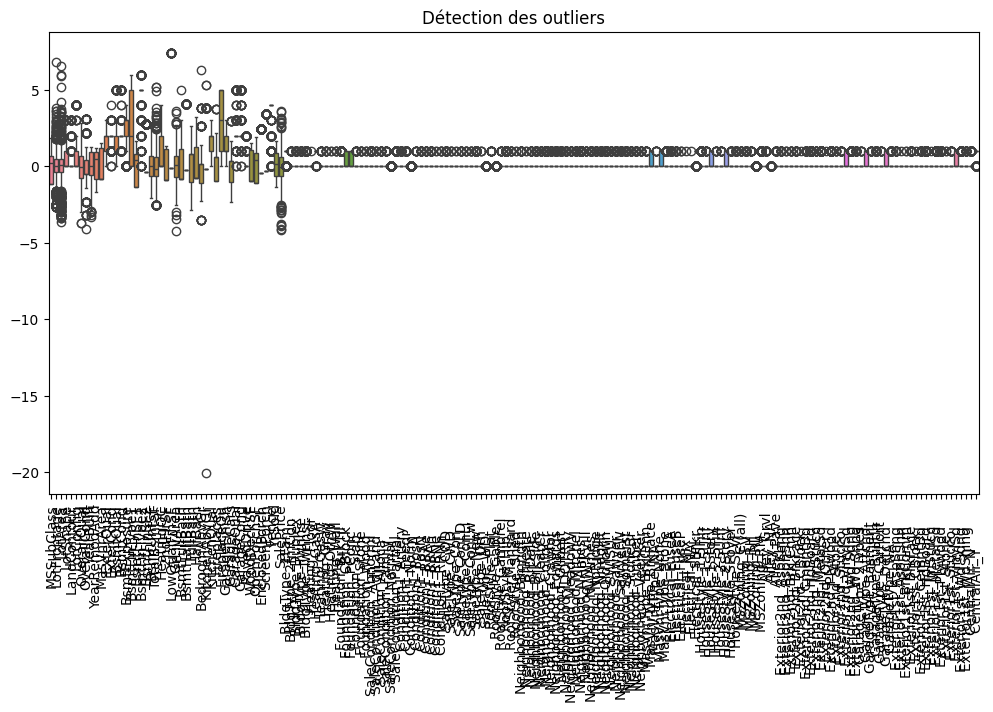

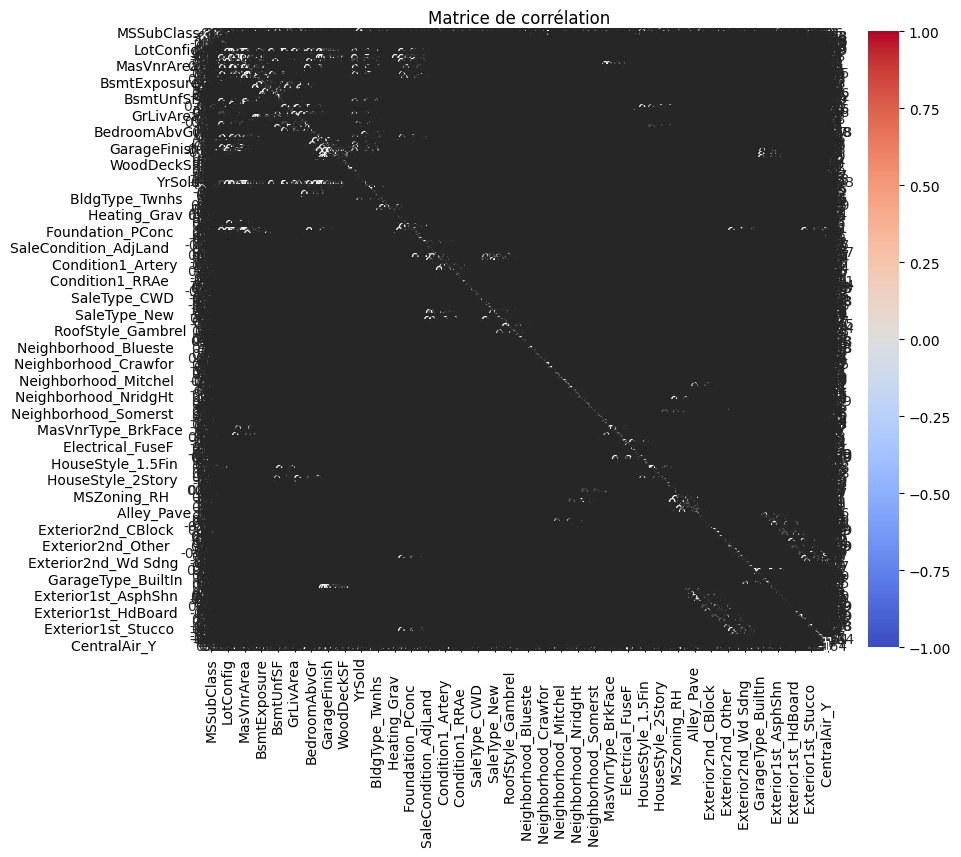


Asymétrie des variables :
LotShape                    1.285160
LandContour                 3.475532
LotConfig                   2.424413
ExterCond                  -1.394028
BsmtQual                    1.293229
                              ...   
Exterior1st_Stucco          7.600443
Exterior1st_Wd Sdng         2.059662
Exterior1st_WdShing         7.286637
CentralAir_N                3.523786
CentralAir_Y               -3.523786
Length: 148, dtype: float64

Mean Squared Error (MSE) : 0.1254
R² Score : 0.8827


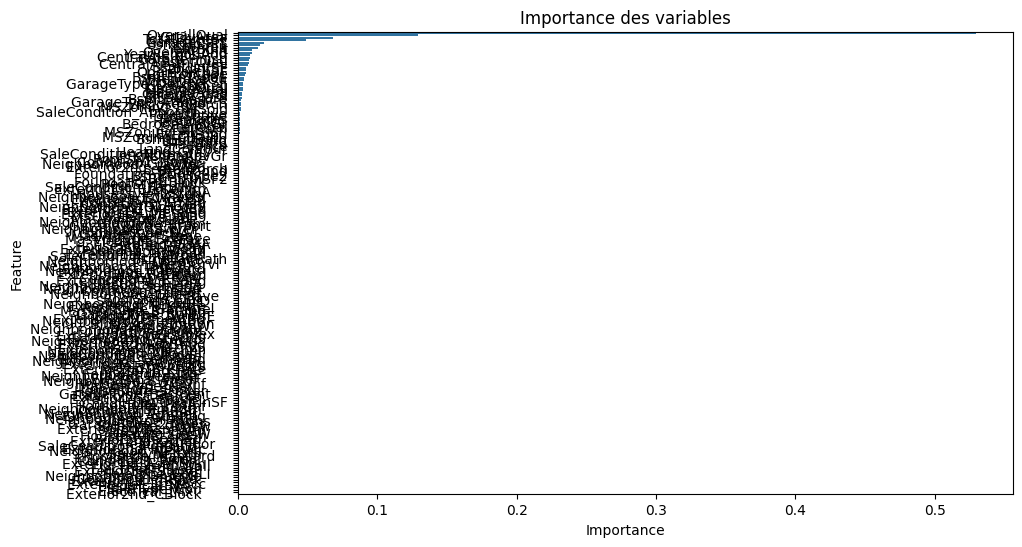

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import skew

# Charger les données
train = pd.read_csv("./dhiaTrain.csv")

# Vérifier les valeurs manquantes
missing_values = train.isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values[missing_values > 0])

# Remplissage des valeurs manquantes (exemple avec la médiane)
train.fillna(train.median(), inplace=True)

# Vérification des statistiques de base
print("\nStatistiques descriptives :")
print(train.describe())

# Détection des outliers avec IQR
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
outliers = ((train < (Q1 - 1.5 * IQR)) | (train > (Q3 + 1.5 * IQR))).sum()
print("\nNombre d'outliers par colonne :")
print(outliers[outliers > 0])

# Visualisation des outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=train)
plt.xticks(rotation=90)
plt.title("Détection des outliers")
plt.show()

# Analyse de la corrélation
correlation_matrix = train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title("Matrice de corrélation")
plt.show()

# Vérification de la distribution des features
skewness = train.apply(lambda x: skew(x.dropna()))
print("\nAsymétrie des variables :")
print(skewness[abs(skewness) > 1])  # Variables fortement asymétriques

# Prétraitement : Séparation des features et target
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

# Encodage des variables catégorielles si nécessaire
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparer les données en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Tester un modèle robuste (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'\nMean Squared Error (MSE) : {mse:.4f}')
print(f'R² Score : {r2:.4f}')

# Importance des variables
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])
plt.title("Importance des variables")
plt.show()
